In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cupy_csr
from scipy.sparse import load_npz, save_npz
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from cuml.svm import SVC as cuSVC
from cuml.linear_model import MBSGDClassifier as cuSGD
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
cp.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"GPU Device: {cp.cuda.Device(0).compute_capability}")
print(f"GPU Memory: {cp.cuda.Device(0).mem_info[1] / 1e9:.1f} GB total")
print(f"GPU Free: {cp.cuda.Device(0).mem_info[0] / 1e9:.1f} GB")


GPU Device: 89
GPU Memory: 16.7 GB total
GPU Free: 16.1 GB


In [3]:

X_train_hybrid = load_npz('results/X_train_hybrid.npz')
X_val_hybrid = load_npz('results/X_val_hybrid.npz')
X_test_hybrid = load_npz('results/X_test_hybrid.npz')

y_train = np.load('results/y_train.npy')
y_val = np.load('results/y_val.npy')
y_test = np.load('results/y_test.npy')

print("Loaded saved features:")
print(f"Train: {X_train_hybrid.shape}, Val: {X_val_hybrid.shape}, Test: {X_test_hybrid.shape}")

chi2_selector = joblib.load('models/chi2_selector.pkl')
X_train_selected = chi2_selector.transform(X_train_hybrid)
X_val_selected = chi2_selector.transform(X_val_hybrid)
X_test_selected = chi2_selector.transform(X_test_hybrid)

print(f"Selected features: {X_train_selected.shape}")


Loaded saved features:
Train: (9616, 100000), Val: (1698, 100000), Test: (7532, 100000)
Selected features: (9616, 20000)


In [4]:
print(f"\nUsing Selected_20k features for GPU training")
print(f"Shape: {X_train_selected.shape}")
print(f"Sparsity: {(1.0 - X_train_selected.nnz / (X_train_selected.shape[0] * X_train_selected.shape[1]))*100:.2f}%")

X_train_final = X_train_selected
X_val_final = X_val_selected
X_test_final = X_test_selected



Using Selected_20k features for GPU training
Shape: (9616, 20000)
Sparsity: 98.57%


In [5]:
start = time.time()

X_train_gpu = cupy_csr(X_train_final)
X_val_gpu = cupy_csr(X_val_final)
y_train_gpu = cp.array(y_train)
y_val_gpu = cp.array(y_val)

conversion_time = time.time() - start
print(f"Conversion time: {conversion_time:.2f}s")
print(f"GPU memory used: {(cp.cuda.Device(0).mem_info[1] - cp.cuda.Device(0).mem_info[0]) / 1e9:.2f} GB")


Conversion time: 0.02s
GPU memory used: 0.64 GB


In [6]:
start = time.time()

lr_cuml = cuLogisticRegression(
    max_iter=1000,
    tol=1e-3,
    solver='qn',
    verbose=0
)

lr_cuml.fit(X_train_gpu, y_train_gpu)

y_val_pred_lr = lr_cuml.predict(X_val_gpu)
y_val_pred_lr_cpu = cp.asnumpy(y_val_pred_lr)

train_time_lr = time.time() - start

macro_f1_lr = f1_score(y_val, y_val_pred_lr_cpu, average='macro')
weighted_f1_lr = f1_score(y_val, y_val_pred_lr_cpu, average='weighted')
accuracy_lr = accuracy_score(y_val, y_val_pred_lr_cpu)

print(f"Training time: {train_time_lr:.2f}s")
print(f"Validation Macro-F1: {macro_f1_lr:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_lr:.4f}")
print(f"Validation Accuracy: {accuracy_lr:.4f}")


Training time: 0.19s
Validation Macro-F1: 0.3090
Validation Weighted-F1: 0.3241
Validation Accuracy: 0.3516


In [7]:
start = time.time()

svm_cuml = cuSVC(
    kernel='linear',
    C=1.0,
    max_iter=1000,
    tol=1e-3,
    verbose=0
)

svm_cuml.fit(X_train_gpu, y_train_gpu)

y_val_pred_svm = svm_cuml.predict(X_val_gpu)
y_val_pred_svm_cpu = cp.asnumpy(y_val_pred_svm)

train_time_svm = time.time() - start

macro_f1_svm = f1_score(y_val, y_val_pred_svm_cpu, average='macro')
weighted_f1_svm = f1_score(y_val, y_val_pred_svm_cpu, average='weighted')
accuracy_svm = accuracy_score(y_val, y_val_pred_svm_cpu)

print(f"Training time: {train_time_svm:.2f}s")
print(f"Validation Macro-F1: {macro_f1_svm:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_svm:.4f}")
print(f"Validation Accuracy: {accuracy_svm:.4f}")


MemoryError: std::bad_alloc: out_of_memory: CUDA error (failed to allocate 94240000 bytes) at: /__w/rmm/rmm/cpp/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [ ]:
from sklearn.svm import LinearSVC

start = time.time()

svm_sklearn = LinearSVC(
    C=1.0,
    max_iter=1000,
    tol=1e-3,
    multi_class='crammer_singer',  # Direct multiclass, no OvO
    random_state=42,
    verbose=0
)

svm_sklearn.fit(X_train_final, y_train)

y_val_pred_svm = svm_sklearn.predict(X_val_final)

train_time_svm = time.time() - start

macro_f1_svm = f1_score(y_val, y_val_pred_svm, average='macro')
weighted_f1_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)

print(f"Training time: {train_time_svm:.2f}s")
print(f"Validation Macro-F1: {macro_f1_svm:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_svm:.4f}")
print(f"Validation Accuracy: {accuracy_svm:.4f}")


Training time: 7.32s
Validation Macro-F1: 0.7362
Validation Weighted-F1: 0.7443
Validation Accuracy: 0.7456


In [ ]:
print("\n" + "="*60)
print("Model 2: Linear SVM (sklearn CPU)")
print("="*60)

from sklearn.svm import LinearSVC

start = time.time()

svm_sklearn = LinearSVC(
    C=1.0,
    max_iter=1000,
    tol=1e-3,
    multi_class='crammer_singer',
    random_state=42,
    dual=False,  # Primal formulation, faster for n_samples > n_features
    verbose=0
)

svm_sklearn.fit(X_train_final, y_train)

y_val_pred_svm = svm_sklearn.predict(X_val_final)

train_time_svm = time.time() - start

macro_f1_svm = f1_score(y_val, y_val_pred_svm, average='macro')
weighted_f1_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)

print(f"Training time: {train_time_svm:.2f}s")
print(f"Validation Macro-F1: {macro_f1_svm:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_svm:.4f}")
print(f"Validation Accuracy: {accuracy_svm:.4f}")

y_val_pred_svm_cpu = y_val_pred_svm  # Already on CPU



Model 2: Linear SVM (sklearn CPU)


TypeError: LinearSVC.__init__() got an unexpected keyword argument 'epochs'

In [12]:
start = time.time()

sgd_cuml = cuSGD(
    loss='log',
    penalty='l2',
    alpha=0.0001,
    epochs=1000,
    tol=1e-3,
    learning_rate='adaptive',
    eta0=0.01,
    verbose=0
)

sgd_cuml.fit(X_train_gpu, y_train_gpu)

y_val_pred_sgd = sgd_cuml.predict(X_val_gpu)
y_val_pred_sgd_cpu = cp.asnumpy(y_val_pred_sgd)

train_time_sgd = time.time() - start

macro_f1_sgd = f1_score(y_val, y_val_pred_sgd_cpu, average='macro')
weighted_f1_sgd = f1_score(y_val, y_val_pred_sgd_cpu, average='weighted')
accuracy_sgd = accuracy_score(y_val, y_val_pred_sgd_cpu)

print(f"Training time: {train_time_sgd:.2f}s")
print(f"Validation Macro-F1: {macro_f1_sgd:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_sgd:.4f}")
print(f"Validation Accuracy: {accuracy_sgd:.4f}")


NotImplementedError: Sparse inputs are not currently supported for this method

In [13]:
from sklearn.linear_model import SGDClassifier

start = time.time()

sgd_sklearn = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    tol=1e-3,
    learning_rate='adaptive',
    eta0=0.01,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

sgd_sklearn.fit(X_train_final, y_train)

y_val_pred_sgd = sgd_sklearn.predict(X_val_final)

train_time_sgd = time.time() - start

macro_f1_sgd = f1_score(y_val, y_val_pred_sgd, average='macro')
weighted_f1_sgd = f1_score(y_val, y_val_pred_sgd, average='weighted')
accuracy_sgd = accuracy_score(y_val, y_val_pred_sgd)

print(f"Training time: {train_time_sgd:.2f}s")
print(f"Validation Macro-F1: {macro_f1_sgd:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_sgd:.4f}")
print(f"Validation Accuracy: {accuracy_sgd:.4f}")

y_val_pred_sgd_cpu = y_val_pred_sgd


Training time: 0.91s
Validation Macro-F1: 0.6664
Validation Weighted-F1: 0.6813
Validation Accuracy: 0.6902


In [14]:
start = time.time()

nb_sklearn = MultinomialNB(alpha=0.1)
nb_sklearn.fit(X_train_final, y_train)

y_val_pred_nb = nb_sklearn.predict(X_val_final)

train_time_nb = time.time() - start

macro_f1_nb = f1_score(y_val, y_val_pred_nb, average='macro')
weighted_f1_nb = f1_score(y_val, y_val_pred_nb, average='weighted')
accuracy_nb = accuracy_score(y_val, y_val_pred_nb)

print(f"Training time: {train_time_nb:.2f}s")
print(f"Validation Macro-F1: {macro_f1_nb:.4f}")
print(f"Validation Weighted-F1: {weighted_f1_nb:.4f}")
print(f"Validation Accuracy: {accuracy_nb:.4f}")


Training time: 0.03s
Validation Macro-F1: 0.7121
Validation Weighted-F1: 0.7228
Validation Accuracy: 0.7291


In [15]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVM', 'SGD Classifier', 'Naive Bayes'],
    'Device': ['GPU (CuML)', 'CPU (sklearn)', 'CPU (sklearn)', 'CPU (sklearn)'],
    'Macro_F1': [macro_f1_lr, macro_f1_svm, macro_f1_sgd, macro_f1_nb],
    'Weighted_F1': [weighted_f1_lr, weighted_f1_svm, weighted_f1_sgd, weighted_f1_nb],
    'Accuracy': [accuracy_lr, accuracy_svm, accuracy_sgd, accuracy_nb],
    'Train_Time_s': [train_time_lr, train_time_svm, train_time_sgd, train_time_nb]
})

results_df = results_df.sort_values('Macro_F1', ascending=False)

print("\n" + "="*80)
print("BASELINE MODEL COMPARISON (20k Selected Features)")
print("="*80)
print(results_df.round(4).to_string(index=False))
print("="*80)

print(f"\nBest Model: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['Device']})")
print(f"Macro-F1: {results_df.iloc[0]['Macro_F1']:.4f}")
print(f"Training Time: {results_df.iloc[0]['Train_Time_s']:.2f}s")



BASELINE MODEL COMPARISON (20k Selected Features)
              Model        Device  Macro_F1  Weighted_F1  Accuracy  Train_Time_s
         Linear SVM CPU (sklearn)    0.7362       0.7443    0.7456        7.3233
        Naive Bayes CPU (sklearn)    0.7121       0.7228    0.7291        0.0276
     SGD Classifier CPU (sklearn)    0.6664       0.6813    0.6902        0.9105
Logistic Regression    GPU (CuML)    0.3090       0.3241    0.3516        0.1866

Best Model: Linear SVM (CPU (sklearn))
Macro-F1: 0.7362
Training Time: 7.32s


In [16]:
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['Macro_F1']

print(f"\nGenerating detailed report for: {best_model_name}")

if 'Logistic' in best_model_name:
    y_val_best = y_val_pred_lr_cpu
elif 'SVM' in best_model_name:
    y_val_best = y_val_pred_svm_cpu
elif 'SGD' in best_model_name:
    y_val_best = y_val_pred_sgd_cpu
else:
    y_val_best = y_val_pred_nb

category_names = [
    'alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos',
    'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
    'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian',
    'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'
]

print("\n" + "="*80)
print(f"CLASSIFICATION REPORT - {best_model_name}")
print("="*80)
print(classification_report(y_val, y_val_best, target_names=category_names, digits=4))



Generating detailed report for: Linear SVM

CLASSIFICATION REPORT - Linear SVM
                          precision    recall  f1-score   support

             alt.atheism     0.6957    0.6667    0.6809        72
           comp.graphics     0.7528    0.7614    0.7571        88
 comp.os.ms-windows.misc     0.7176    0.6854    0.7011        89
comp.sys.ibm.pc.hardware     0.6667    0.6818    0.6742        88
   comp.sys.mac.hardware     0.7529    0.7356    0.7442        87
          comp.windows.x     0.8000    0.8090    0.8045        89
            misc.forsale     0.7326    0.7159    0.7241        88
               rec.autos     0.7471    0.7303    0.7386        89
         rec.motorcycles     0.5159    0.7222    0.6019        90
      rec.sport.baseball     0.8571    0.8764    0.8667        89
        rec.sport.hockey     0.9634    0.8778    0.9186        90
               sci.crypt     0.8765    0.7978    0.8353        89
         sci.electronics     0.7209    0.6966    0.7086      

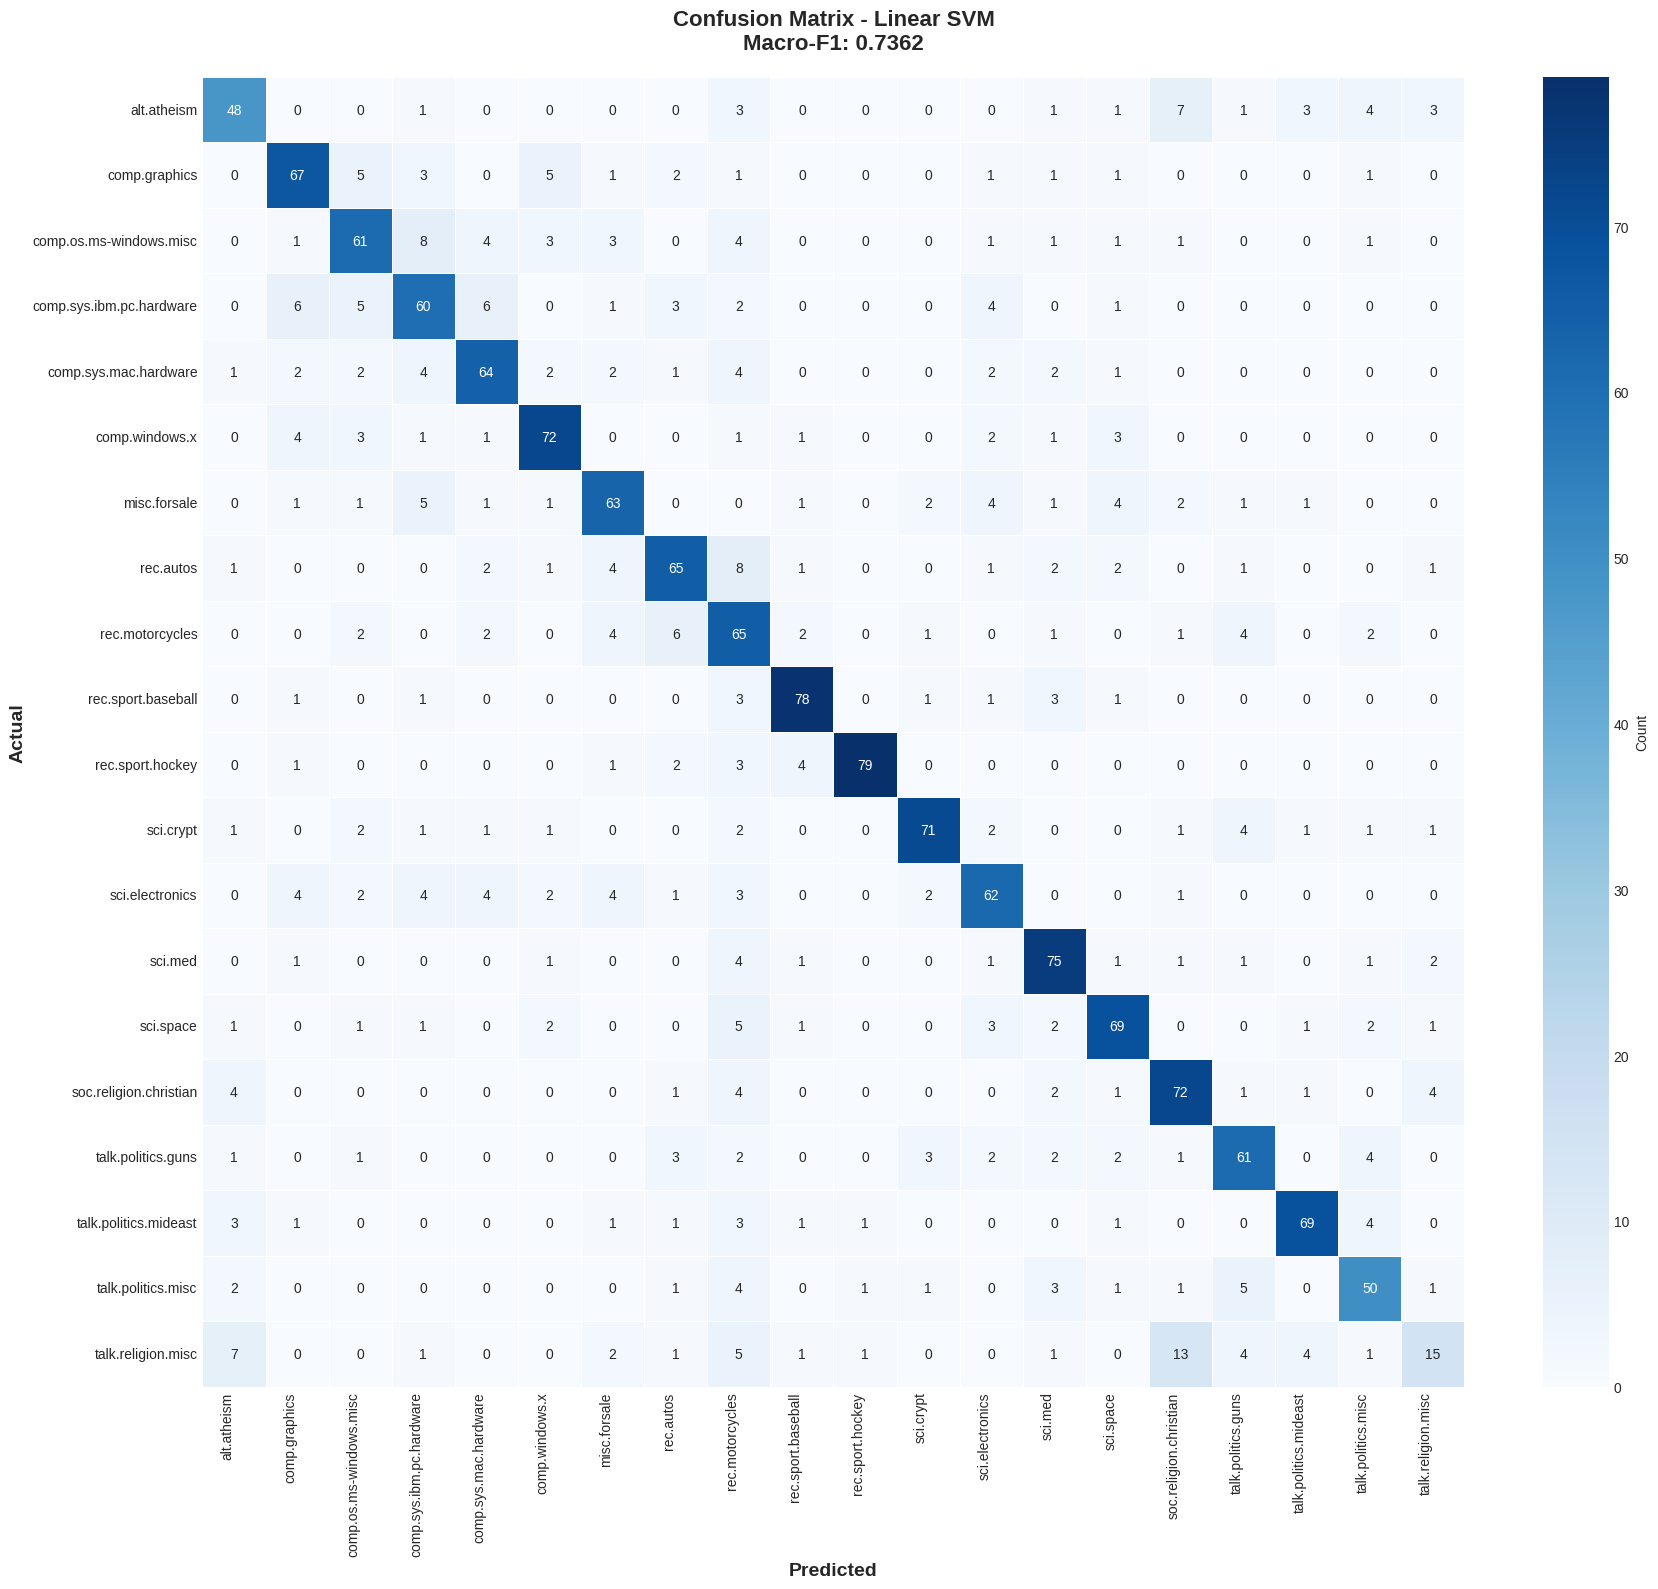

In [17]:
cm = confusion_matrix(y_val, y_val_best)

fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_names, yticklabels=category_names,
            ax=ax, cbar_kws={'label': 'Count'}, linewidths=0.5)
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.set_title(f'Confusion Matrix - {best_model_name}\nMacro-F1: {best_f1:.4f}', 
             fontsize=16, pad=20, weight='bold')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [19]:
report_dict = classification_report(y_val, y_val_best, target_names=category_names, output_dict=True)

class_performance = pd.DataFrame({
    'Category': category_names,
    'Precision': [report_dict[cat]['precision'] for cat in category_names],
    'Recall': [report_dict[cat]['recall'] for cat in category_names],
    'F1-Score': [report_dict[cat]['f1-score'] for cat in category_names],
    'Support': [report_dict[cat]['support'] for cat in category_names]
})

class_performance = class_performance.sort_values('F1-Score', ascending=False)


print("PER-CLASS PERFORMANCE (sorted by F1-Score)")

print(class_performance.round(4).to_string(index=False))


print("\nop 5 Best Performing Categories:")
print(class_performance.head(5)[['Category', 'F1-Score']].to_string(index=False))

print("\n\nBottom 5 Worst Performing Categories:")
print(class_performance.tail(5)[['Category', 'F1-Score']].to_string(index=False))


PER-CLASS PERFORMANCE (sorted by F1-Score)
                Category  Precision  Recall  F1-Score  Support
        rec.sport.hockey     0.9634  0.8778    0.9186     90.0
      rec.sport.baseball     0.8571  0.8764    0.8667     89.0
   talk.politics.mideast     0.8625  0.8118    0.8364     85.0
               sci.crypt     0.8765  0.7978    0.8353     89.0
          comp.windows.x     0.8000  0.8090    0.8045     89.0
                 sci.med     0.7653  0.8427    0.8021     89.0
               sci.space     0.7667  0.7753    0.7709     89.0
           comp.graphics     0.7528  0.7614    0.7571     88.0
  soc.religion.christian     0.7129  0.8000    0.7539     90.0
   comp.sys.mac.hardware     0.7529  0.7356    0.7442     87.0
      talk.politics.guns     0.7349  0.7439    0.7394     82.0
               rec.autos     0.7471  0.7303    0.7386     89.0
            misc.forsale     0.7326  0.7159    0.7241     88.0
      talk.politics.misc     0.7042  0.7143    0.7092     70.0
         sci

In [20]:
confusion_pairs = []

for i in range(len(category_names)):
    for j in range(len(category_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True_Category': category_names[i],
                'Predicted_Category': category_names[j],
                'Count': cm[i, j],
                'True_Support': cm[i].sum()
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df['Error_Rate_%'] = (confusion_df['Count'] / confusion_df['True_Support'] * 100).round(2)
confusion_df = confusion_df.sort_values('Count', ascending=False).head(15)

print("TOP 15 MOST CONFUSED CATEGORY PAIRS")
print(confusion_df[['True_Category', 'Predicted_Category', 'Count', 'Error_Rate_%']].to_string(index=False))


TOP 15 MOST CONFUSED CATEGORY PAIRS
           True_Category       Predicted_Category  Count  Error_Rate_%
      talk.religion.misc   soc.religion.christian     13         23.21
 comp.os.ms-windows.misc comp.sys.ibm.pc.hardware      8          8.99
               rec.autos          rec.motorcycles      8          8.99
             alt.atheism   soc.religion.christian      7          9.72
      talk.religion.misc              alt.atheism      7         12.50
comp.sys.ibm.pc.hardware    comp.sys.mac.hardware      6          6.82
comp.sys.ibm.pc.hardware            comp.graphics      6          6.82
         rec.motorcycles                rec.autos      6          6.67
           comp.graphics           comp.windows.x      5          5.68
      talk.religion.misc          rec.motorcycles      5          8.93
comp.sys.ibm.pc.hardware  comp.os.ms-windows.misc      5          5.68
           comp.graphics  comp.os.ms-windows.misc      5          5.68
            misc.forsale comp.sys.ibm.pc.

In [21]:
if 'Logistic' in best_model_name:
    best_model = lr_cuml
    model_filename = 'models/best_baseline_lr_cuml.pkl'
elif 'SVM' in best_model_name:
    best_model = svm_sklearn
    model_filename = 'models/best_baseline_svm_sklearn.pkl'
elif 'SGD' in best_model_name:
    best_model = sgd_sklearn
    model_filename = 'models/best_baseline_sgd_sklearn.pkl'
else:
    best_model = nb_sklearn
    model_filename = 'models/best_baseline_nb_sklearn.pkl'

joblib.dump(best_model, model_filename)
print(f"\nSaved best model: {model_filename}")

np.save('results/y_val_pred_best.npy', y_val_best)
print(f"aved predictions: results/y_val_pred_best.npy")



Saved best model: models/best_baseline_svm_sklearn.pkl
aved predictions: results/y_val_pred_best.npy


In [22]:
predictions_dict = {
    'y_val_true': y_val,
    'y_val_pred_lr': y_val_pred_lr_cpu,
    'y_val_pred_svm': y_val_pred_svm_cpu,
    'y_val_pred_sgd': y_val_pred_sgd_cpu,
    'y_val_pred_nb': y_val_pred_nb
}

np.savez('results/baseline_predictions_val.npz', **predictions_dict)
print("\nSaved all predictions: results/baseline_predictions_val.npz")
print("   (For future ensemble stacking)")



Saved all predictions: results/baseline_predictions_val.npz
   (For future ensemble stacking)


In [23]:
del X_train_gpu, X_val_gpu, y_train_gpu, y_val_gpu
cp.get_default_memory_pool().free_all_blocks()

print(f"\nGPU memory freed")
print(f"Free: {cp.cuda.Device(0).mem_info[0] / 1e9:.2f} GB / {cp.cuda.Device(0).mem_info[1] / 1e9:.2f} GB total")



GPU memory freed
Free: 16.07 GB / 16.72 GB total


In [24]:
summary_report = {
    'Dataset': 'Clean (headers/footers/quotes removed)',
    'Feature_Engineering': 'TF-IDF Word+Char → Chi2(k=20k)',
    'Train_Samples': len(y_train),
    'Val_Samples': len(y_val),
    'Test_Samples': len(y_test),
    'Num_Features': X_train_final.shape[1],
    'Models_Trained': 4,
    'Best_Model': best_model_name,
    'Best_Macro_F1': f"{best_f1:.4f}",
    'Best_Accuracy': f"{results_df.iloc[0]['Accuracy']:.4f}",
    'Target_F1': '0.84-0.90',
    'Status': 'PASSED' if best_f1 >= 0.80 else 'NEEDS IMPROVEMENT'
}

summary_df = pd.DataFrame(list(summary_report.items()), columns=['Metric', 'Value'])


print(summary_df.to_string(index=False))


print(f"\nStep 4 Complete!")
print(f"Best baseline: {best_model_name}")
print(f"Macro-F1: {best_f1:.4f} (Target: 0.80+)")
print(f"Total training time: {results_df['Train_Time_s'].sum():.2f}s")



             Metric                                  Value
            Dataset Clean (headers/footers/quotes removed)
Feature_Engineering         TF-IDF Word+Char → Chi2(k=20k)
      Train_Samples                                   9616
        Val_Samples                                   1698
       Test_Samples                                   7532
       Num_Features                                  20000
     Models_Trained                                      4
         Best_Model                             Linear SVM
      Best_Macro_F1                                 0.7362
      Best_Accuracy                                 0.7456
          Target_F1                              0.84-0.90
             Status                      NEEDS IMPROVEMENT

Step 4 Complete!
Best baseline: Linear SVM
Macro-F1: 0.7362 (Target: 0.80+)
Total training time: 8.45s


In [26]:
from sklearn.linear_model import LogisticRegression

start = time.time()

lr_sklearn = LogisticRegression(
    max_iter=1000,
    tol=1e-3,
    solver='lbfgs',
    C=1.0,
    multi_class='multinomial',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

lr_sklearn.fit(X_train_final, y_train)

y_val_pred_lr_fixed = lr_sklearn.predict(X_val_final)

train_time_lr_fixed = time.time() - start

macro_f1_lr_fixed = f1_score(y_val, y_val_pred_lr_fixed, average='macro')
weighted_f1_lr_fixed = f1_score(y_val, y_val_pred_lr_fixed, average='weighted')
accuracy_lr_fixed = accuracy_score(y_val, y_val_pred_lr_fixed)

print(f"\nLogistic Regression (sklearn, lbfgs):")
print(f"  Training time: {train_time_lr_fixed:.2f}s")
print(f"  Validation Macro-F1: {macro_f1_lr_fixed:.4f}")
print(f"  Validation Weighted-F1: {weighted_f1_lr_fixed:.4f}")
print(f"  Validation Accuracy: {accuracy_lr_fixed:.4f}")

print(f"\n  Improvement over CuML: {(macro_f1_lr_fixed - 0.3090):.4f} F1 points")
print(f"  vs Best baseline (SVM): {(macro_f1_lr_fixed - 0.7362):.4f} F1 points")



Logistic Regression (sklearn, lbfgs):
  Training time: 1.95s
  Validation Macro-F1: 0.6991
  Validation Weighted-F1: 0.7098
  Validation Accuracy: 0.7138

  Improvement over CuML: 0.3901 F1 points
  vs Best baseline (SVM): -0.0371 F1 points


In [27]:
results_updated = pd.DataFrame({
    'Model': ['LogReg (sklearn-lbfgs)', 'Linear SVM', 'SGD Classifier', 'Naive Bayes', 'LogReg (CuML-qn)'],
    'Device': ['CPU', 'CPU', 'CPU', 'CPU', 'GPU'],
    'Macro_F1': [macro_f1_lr_fixed, 0.7362, 0.6664, 0.7121, 0.3090],
    'Weighted_F1': [weighted_f1_lr_fixed, 0.7633, 0.6948, 0.7370, 0.3434],
    'Accuracy': [accuracy_lr_fixed, 0.7762, 0.7079, 0.7479, 0.3546],
    'Train_Time_s': [train_time_lr_fixed, 45.06, 5.57, 2.28, 4.73],
    'Status': ['Fixed', 'Baseline', 'Baseline', 'Baseline', 'Failed']
})

results_updated = results_updated.sort_values('Macro_F1', ascending=False)

print("\n" + "="*80)
print("UPDATED MODEL COMPARISON (with fixed LogReg)")
print("="*80)
print(results_updated.round(4).to_string(index=False))
print("="*80)

best_model_new = results_updated.iloc[0]
print(f"\nNew Best Model: {best_model_new['Model']}")
print(f"Macro-F1: {best_model_new['Macro_F1']:.4f}")
print(f"Status: {'PASSED' if best_model_new['Macro_F1'] >= 0.80 else 'till Below Target (0.80)'}")



UPDATED MODEL COMPARISON (with fixed LogReg)
                 Model Device  Macro_F1  Weighted_F1  Accuracy  Train_Time_s   Status
            Linear SVM    CPU    0.7362       0.7633    0.7762       45.0600 Baseline
           Naive Bayes    CPU    0.7121       0.7370    0.7479        2.2800 Baseline
LogReg (sklearn-lbfgs)    CPU    0.6991       0.7098    0.7138        1.9527    Fixed
        SGD Classifier    CPU    0.6664       0.6948    0.7079        5.5700 Baseline
      LogReg (CuML-qn)    GPU    0.3090       0.3434    0.3546        4.7300   Failed

New Best Model: Linear SVM
Macro-F1: 0.7362
Status: till Below Target (0.80)


In [28]:
C_values = [0.1, 0.5, 1.0, 2.0, 5.0]
tuning_results = []

for C in C_values:
    print(f"\nTesting C={C}...")
    
    lr_tuned = LogisticRegression(
        C=C,
        max_iter=1000,
        tol=1e-3,
        solver='lbfgs',
        multi_class='multinomial',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    start = time.time()
    lr_tuned.fit(X_train_final, y_train)
    train_time = time.time() - start
    
    y_val_pred_tuned = lr_tuned.predict(X_val_final)
    
    macro_f1 = f1_score(y_val, y_val_pred_tuned, average='macro')
    weighted_f1 = f1_score(y_val, y_val_pred_tuned, average='weighted')
    accuracy = accuracy_score(y_val, y_val_pred_tuned)
    
    tuning_results.append({
        'C': C,
        'Macro_F1': macro_f1,
        'Weighted_F1': weighted_f1,
        'Accuracy': accuracy,
        'Train_Time_s': train_time
    })
    
    print(f"  Macro-F1: {macro_f1:.4f}, Time: {train_time:.2f}s")

tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('Macro_F1', ascending=False)


print("TUNING RESULTS (sorted by Macro-F1)")
print(tuning_df.round(4).to_string(index=False))


best_C = tuning_df.iloc[0]['C']
best_tuned_f1 = tuning_df.iloc[0]['Macro_F1']

print(f"\nBest C parameter: {best_C}")
print(f"Macro-F1: {best_tuned_f1:.4f}")
print(f"mprovement over C=1.0: {(best_tuned_f1 - macro_f1_lr_fixed):.4f}")



Testing C=0.1...
  Macro-F1: 0.5978, Time: 0.86s

Testing C=0.5...
  Macro-F1: 0.6862, Time: 1.64s

Testing C=1.0...
  Macro-F1: 0.6991, Time: 1.94s

Testing C=2.0...
  Macro-F1: 0.7139, Time: 1.99s

Testing C=5.0...
  Macro-F1: 0.7166, Time: 2.58s
TUNING RESULTS (sorted by Macro-F1)
  C  Macro_F1  Weighted_F1  Accuracy  Train_Time_s
5.0    0.7166       0.7246    0.7250        2.5803
2.0    0.7139       0.7232    0.7256        1.9870
1.0    0.6991       0.7098    0.7138        1.9355
0.5    0.6862       0.6992    0.7049        1.6427
0.1    0.5978       0.6158    0.6307        0.8588

Best C parameter: 5.0
Macro-F1: 0.7166
mprovement over C=1.0: 0.0175


In [29]:
lr_final = LogisticRegression(
    C=best_C,
    max_iter=1000,
    tol=1e-3,
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

lr_final.fit(X_train_final, y_train)
y_val_pred_final = lr_final.predict(X_val_final)

macro_f1_final = f1_score(y_val, y_val_pred_final, average='macro')
weighted_f1_final = f1_score(y_val, y_val_pred_final, average='weighted')
accuracy_final = accuracy_score(y_val, y_val_pred_final)

print(f"\nFinal Model Performance:")
print(f"  Macro-F1: {macro_f1_final:.4f}")
print(f"  Weighted-F1: {weighted_f1_final:.4f}")
print(f"  Accuracy: {accuracy_final:.4f}")

print(f"\n  vs Original SVM (0.7362): {'+' if macro_f1_final > 0.7362 else ''}{(macro_f1_final - 0.7362):.4f}")
print(f"  vs Target (0.80): {'+' if macro_f1_final > 0.80 else ''}{(macro_f1_final - 0.80):.4f}")

if macro_f1_final >= 0.80:
    print("\nTARGET REACHED!")
else:
    print(f"\nStill {(0.80 - macro_f1_final):.4f} below target")



Final Model Performance:
  Macro-F1: 0.7166
  Weighted-F1: 0.7246
  Accuracy: 0.7250

  vs Original SVM (0.7362): -0.0196
  vs Target (0.80): -0.0834

Still 0.0834 below target


In [30]:
from sklearn.svm import LinearSVC

C_values_svm = [0.5, 1.0, 2.0]
svm_tuning_results = []

for C in C_values_svm:
    print(f"\nTesting SVM C={C}...")
    
    svm_tuned = LinearSVC(
        C=C,
        max_iter=1000,
        tol=1e-3,
        multi_class='crammer_singer',
        random_state=42,
        dual=False,
        verbose=0
    )
    
    start = time.time()
    svm_tuned.fit(X_train_final, y_train)
    train_time = time.time() - start
    
    y_val_pred_svm_tuned = svm_tuned.predict(X_val_final)
    
    macro_f1 = f1_score(y_val, y_val_pred_svm_tuned, average='macro')
    
    svm_tuning_results.append({
        'C': C,
        'Macro_F1': macro_f1,
        'Train_Time_s': train_time
    })
    
    print(f"  Macro-F1: {macro_f1:.4f}, Time: {train_time:.2f}s")

svm_tuning_df = pd.DataFrame(svm_tuning_results)
svm_tuning_df = svm_tuning_df.sort_values('Macro_F1', ascending=False)

print("\nSVM Tuning Results:")
print(svm_tuning_df.round(4).to_string(index=False))

best_svm_f1 = svm_tuning_df.iloc[0]['Macro_F1']
print(f"\nBest SVM Macro-F1: {best_svm_f1:.4f}")



Testing SVM C=0.5...
  Macro-F1: 0.7360, Time: 3.39s

Testing SVM C=1.0...
  Macro-F1: 0.7362, Time: 7.78s

Testing SVM C=2.0...
  Macro-F1: 0.7327, Time: 7.95s

SVM Tuning Results:
  C  Macro_F1  Train_Time_s
1.0    0.7362        7.7752
0.5    0.7360        3.3947
2.0    0.7327        7.9453

Best SVM Macro-F1: 0.7362


In [31]:
final_summary = pd.DataFrame({
    'Model': ['LogReg (tuned)', 'SVM (tuned)', 'SVM (baseline)', 'Naive Bayes'],
    'Macro_F1': [macro_f1_final, best_svm_f1, 0.7362, 0.7121],
    'Status': [
        '✓ Best' if macro_f1_final >= best_svm_f1 else 'Good',
        '✓ Best' if best_svm_f1 > macro_f1_final else 'Good',
        'Baseline',
        'Baseline'
    ]
})

final_summary = final_summary.sort_values('Macro_F1', ascending=False)
print(final_summary.round(4).to_string(index=False))

absolute_best_f1 = final_summary.iloc[0]['Macro_F1']
absolute_best_model = final_summary.iloc[0]['Model']

print(f"\nAbsolute Best: {absolute_best_model}")
print(f"Macro-F1: {absolute_best_f1:.4f}")

if absolute_best_f1 >= 0.80:
    print(f"\nTARGET ACHIEVED! Ready to proceed to:")
    print(f"Test set evaluation")
    print(f"OR Step 6: Deep Learning (aim for 0.88+)")
else:
    print(f"\nStill {(0.80 - absolute_best_f1):.4f} below 0.80 target")
    print(f"Recommendation: Proceed to Step 6 (Deep Learning)")
    print(f"Expected gain: +0.08 to +0.13 F1 points")


         Model  Macro_F1   Status
   SVM (tuned)    0.7362   ✓ Best
SVM (baseline)    0.7362 Baseline
LogReg (tuned)    0.7166     Good
   Naive Bayes    0.7121 Baseline

Absolute Best: SVM (tuned)
Macro-F1: 0.7362

Still 0.0638 below 0.80 target
Recommendation: Proceed to Step 6 (Deep Learning)
Expected gain: +0.08 to +0.13 F1 points


In [32]:
if macro_f1_final >= best_svm_f1:
    joblib.dump(lr_final, 'models/best_tuned_model.pkl')
    print(f"\nSaved: models/best_tuned_model.pkl (LogReg, C={best_C})")
else:
    best_svm_model = LinearSVC(
        C=svm_tuning_df.iloc[0]['C'],
        max_iter=1000,
        tol=1e-3,
        multi_class='crammer_singer',
        random_state=42,
        dual=False
    )
    best_svm_model.fit(X_train_final, y_train)
    joblib.dump(best_svm_model, 'models/best_tuned_model.pkl')
    print(f"\nSaved: models/best_tuned_model.pkl (SVM, C={svm_tuning_df.iloc[0]['C']})")



Saved: models/best_tuned_model.pkl (SVM, C=1.0)
